## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import seaborn

2023-02-19 15:50:01.623832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generating Data using Kozeny-Carman equation

In [2]:
# Define boundaries for porosity, specific surface area, and Kozeny-Carman constant
por_min, por_max = 0.1, 0.4
ssa_min, ssa_max = 0.1, 100
kc_min, kc_max = 0.1, 10

# Define number of data points
n = 5000

# Generate random values for porosity, specific surface area, and Kozeny-Carman constant
porosity = np.random.uniform(low=por_min, high=por_max, size=n)
ssa = np.random.uniform(low=ssa_min, high=ssa_max, size=n)
kc = np.random.uniform(low=kc_min, high=kc_max, size=n)

# Calculate permeability using the Kozeny-Carman equation
permeability = (porosity**3 * kc) / (ssa**2 * (1 - porosity)**2)

# Make sure permeability values are positive
permeability = np.abs(permeability)

## Normalization and data splitting

In [3]:
# Normalize the data
scaler = MinMaxScaler()
porosity_scaled = scaler.fit_transform(porosity.reshape(-1,1))
ssa_scaled = scaler.fit_transform(ssa.reshape(-1,1))
kc_scaled = scaler.fit_transform(kc.reshape(-1,1))
permeability_scaled = scaler.fit_transform(permeability.reshape(-1,1))

In [4]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((porosity_scaled, ssa_scaled, kc_scaled), axis=1),
    permeability_scaled,
    test_size=0.2,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42
)

## Model Architecture, Compiling and Evaluation

In [5]:
# Define the model architecture
model = Sequential()
model.add(Dense(16, input_dim=3, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and save history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0,
                    validation_data=(X_val, y_val))


# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)
permeability_denorm = scaler.inverse_transform(permeability_scaled)
y_test_denorm = scaler.inverse_transform(y_test)
y_pred_denorm = scaler.inverse_transform(model.predict(X_test))
r2 = 1 - mse/np.var(permeability_denorm)
print(f'Test MSE: {mse:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Test R^2: {r2:.4f}')

2023-02-19 15:50:19.118605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


32/32 [==============================] - 0s 1ms/step
Test MSE: 0.0000
Test RMSE: 0.0055
Test R^2: 0.9994


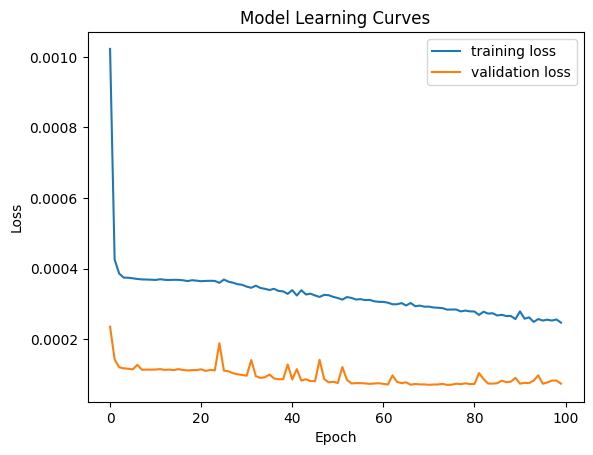

In [6]:
# Plot learning curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()